In [1]:
import findspark
findspark.init()

In [2]:
import pyspark

In [3]:
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc

In [4]:
sc = SparkContext()

In [5]:
# 1 bacth lưu 10 giây
ssc = StreamingContext(sc, 10 ) # batch_size: batch duration time
sqlContext = SQLContext(sc)

In [6]:
# Tạo socket stream
socket_stream = ssc.socketTextStream("127.0.0.1", 5555) # local machine: host, port

In [7]:
# tạo DStream, lưu các line, 1 cửa sổ lưu 20 lines
lines = socket_stream.window( 20 ) 

In [8]:
# Create a class Tweet via namedtuple
from collections import namedtuple
# Với mỗi tweet sẽ có tên tag và count
fields = ("tag", "count" )
Tweet = namedtuple( 'Tweet', fields )

In [9]:
# transform dstream, 
# input > spark streaming > dstream > phải transform để có dữ liệu xài được 
# flatmap để list, đọc thông tin từng dòng, filter hashtags dấu #
# transform thành chữ thường (lower words)
# rmove những tag trùng nhau rồi count lên
# lưu trữ trong rec
# chuyển về dataframe từ RDD, sort theo count
# refresh sau 10 giây
( lines.flatMap( lambda text: text.split( " " ) ) # Grab the tweet line and split it into a word list.
  .filter( lambda word: word.lower().startswith("#") ) # Check for hashtag calls. Filter the message with the hashtag.
  .map( lambda word: ( word.lower(), 1 ) ) # Convert the words to lowercase.
  .reduceByKey( lambda a, b: a + b ) # Count and remove duplicates.
  .map( lambda rec: Tweet( rec[0], rec[1] ) ) # Store the words in the Tweet object.
  .foreachRDD( lambda rdd: rdd.toDF().sort( desc("count") ) # Sort them in a DataFrame.
  .limit(10).registerTempTable("tweets") ) ) #Register to a table. (Refreshes will be executed every 10 seconds.)

Now run TweetRead_new.py
At folder containing TweetRead_new.py > type cmd > python TweetRead_new.py >> tweets_covid_19.txt
Choose some famous hashtags to check, link: https://www.tweeplers.com/hashtags/?cc=WORLD

In [10]:
#  run the pyspark Stream instance
ssc.start()

In [11]:
import time
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
# Only works for Jupyter Notebooks!
%matplotlib inline 

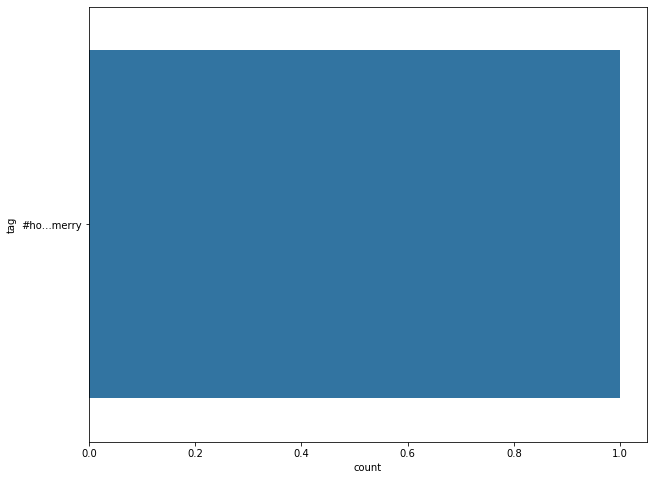

In [12]:
# Make 10 plots
# Before each of them, set the sleep time to 10 seconds (or other value, ex: 10 seconds)
# grab the top 10 tweets from SQLContext instance. 
# transform the results to a DataFrame and build a plot for each of them.
# The result will be a plot that will change every 10 seconds.
try:
    count = 0
    while count < 10:    
        time.sleep( 10 )
        top_10_tweets = sqlContext.sql( 'Select tag, count from tweets' )
        top_10_df = top_10_tweets.toPandas()
        display.clear_output(wait=True)
        plt.figure( figsize = ( 10, 8 ) )
        sns.barplot( x="count", y="tag", data=top_10_df)
        plt.show()
        count = count + 1
except:
    print("No tweets now")

In [13]:
# break trên cmd trước khi stop
ssc.stop()